# Working with data from the HPF Spectrograph

by Michael Gully-Santiago & Jessica Luna

`muler` has new *beta support* for the [Habitable Zone Planet Finder Spectrograph](https://hpf.psu.edu/) (HPF).  In this tutorial we show the basic usage of how to read, process, and plot data from HPF.  We currently support data from either the Goldilocks pipeline or HPF Instrument Team pipeline.

In [1]:
from muler.hpf import HPFSpectrum, HPFSpectrumList
import numpy as np
import glob

%config InlineBackend.figure_format='retina'

In order to use `muler` with HPF data, you need to have some spectra on your computer.  Here we have Goldilocks spectra:

In [2]:
local_files = glob.glob("../../../muler_example_data/HPF/01_A0V_standards/Goldilocks_*.spectra.fits")
file = local_files[0]

We can easily read in HPF data for a specific spectral order:

In [3]:
original_spectrum = HPFSpectrum(file=file, order=15)

In [4]:
original_spectrum.sky

<Spectrum1D(flux=<Quantity [0., 0., 0., ..., 0., 0., 0.] ct>, spectral_axis=<SpectralAxis [10099.10599397, 10099.18002891, 10099.25405465, ..., 10229.09963838,
   10229.15216336, 10229.20467699] Angstrom>, uncertainty=StdDevUncertainty([0., 0., 0., ..., 0., 0., 0.]))>

In [6]:
original_spectrum.ancillary_spectra

['sky', 'lfc']

The spectrum has physical units:

In [7]:
original_spectrum.wavelength # "Angstroms"

<SpectralAxis [10099.10445599, 10099.17849651, 10099.25252783, ..., 10229.10640794,
   10229.1589311 , 10229.21144287] Angstrom>

In [8]:
original_spectrum.flux.unit # "counts"

Unit("ct")

In [9]:
original_spectrum.sky.flux.unit

Unit("ct")

We can normalize the spectrum, which divides the spectrum by the median value, rendering the flux units *dimensionless*

In [10]:
spectrum = original_spectrum.normalize()
np.nanmedian(spectrum.flux)

<Quantity 1.>

We can effortlessly subtract the sky emission from the target fiber.

In [13]:
sky_free_spectrum = spectrum.sky_subtract(method='vector')

Now we can normalize and overplot plot the observed spectrum, sky subtracted spectrum, and the sky emission itself:

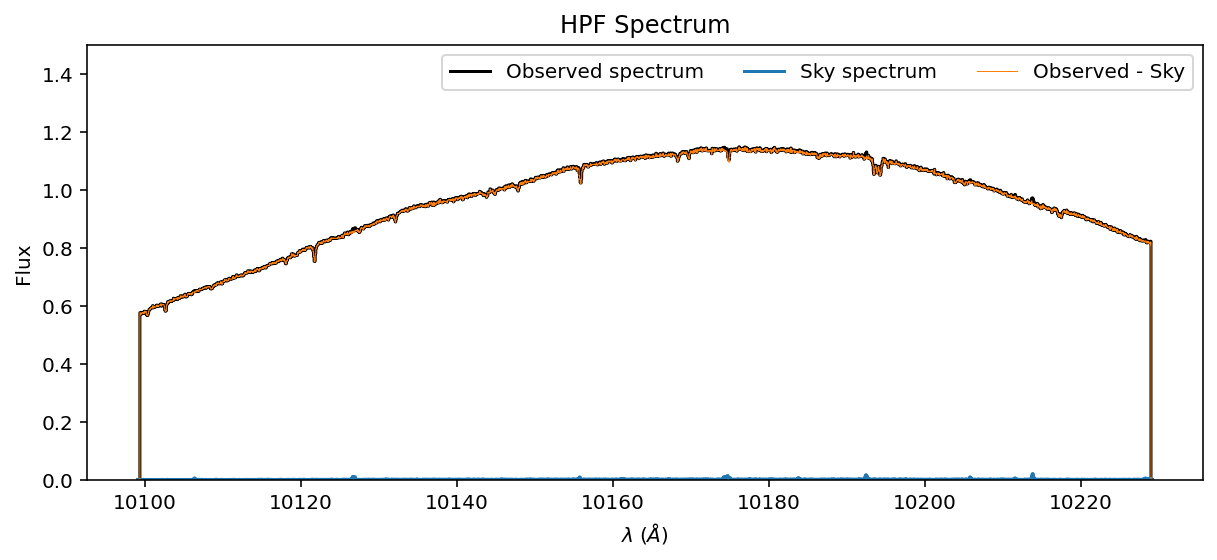

In [14]:
ax = spectrum.plot(label='Observed spectrum', color='k')
spectrum.sky.plot(ax=ax, label='Sky spectrum')
sky_free_spectrum.plot(ax=ax, label='Observed - Sky', lw=0.5)
ax.legend(ncol=3); ax.set_ylim(0.0, 1.5);

Nice! We have a sky subtracted spectrum!  Let's remove the instrumental response function from this sky subtracted spectrum.  The instrumental response is dominated by the characteristic concave-down shape.  This conspicuous parabola-like curve stems from an optical device called an [echelle grating](https://en.wikipedia.org/wiki/Echelle_grating) and its related "blaze function".  Accordingly the process of removing this shape is sometimes referred to by the names "de-blazing", "flattening", or "normalizing".  In this tutorial we will stick with the term "deblaze".

We first want to remove the `NaN` values at the edges, then apply the spline division:

In [16]:
deblazed_spectrum = sky_free_spectrum.remove_nans().deblaze()

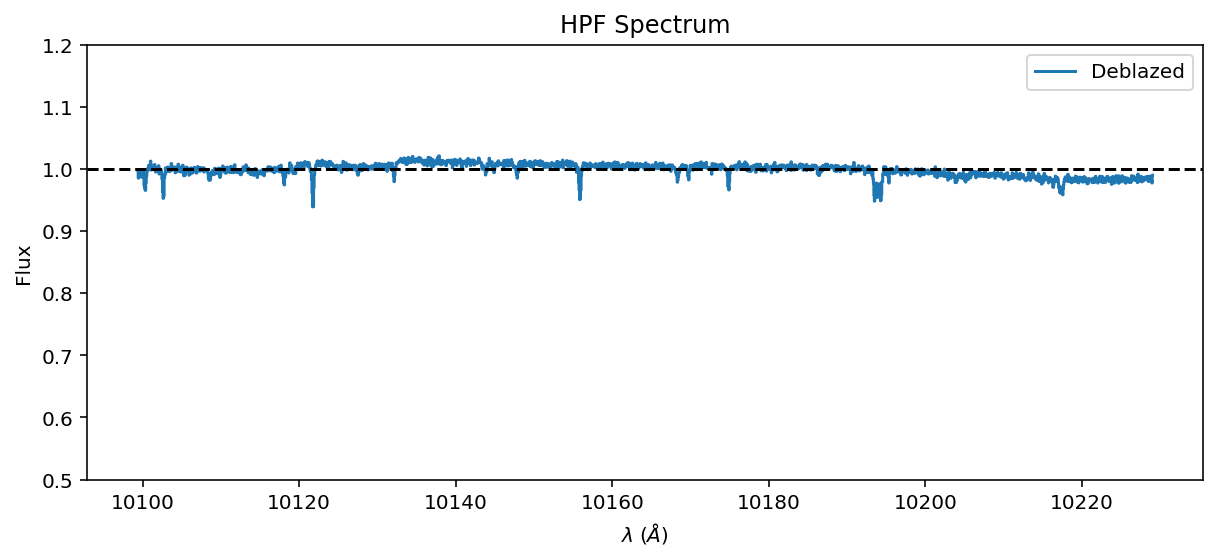

In [18]:
ax = deblazed_spectrum.normalize().plot(label='Deblazed')
ax.axhline(1.0, linestyle='dashed', color='k')
ax.set_ylim(0.5, 1.2); ax.legend();

Great!  We have achieved our goal: sky subtracted and deblazed target spectrum ready for analysis.

You can see that the spline division is not perfect because some broad line wings can be mistaken as part of the blaze shape.  `muler` has experimental support for a different type of deblazing based on high-fidelity [flat-field](https://en.wikipedia.org/wiki/Flat-field_correction) spectra.  Those experimental techniques currently require ancillary calibration files that are not provided with our git repo.  Check back in for future updates!